#  3. Modelado con LSTM
El modelo Long Short-Term Memory es una arquitectura de red neuronal recurrente (RNN) que podría ser muy eficaz para nuestra serie temporal debido a su capacidad para retener información a largo plazo y capturar dependencias temporales. Vamos a implementar el modelo utilizando Keras de TensorFlow. Para ello, crearemos un nuevo entorno de Anaconda en el que instalaremos Python v3.10 (última versión compatible con TF), TensorFlow y el resto de bibliotecas necesarias.

#### Importamos las bibliotecas

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt

#### Convertimos la serie temporal en secuencias
Es necesario normalizar los datos entre 0 y 1 para mejorar la precisión en redes neuronales

In [32]:
data_biodiesel = pd.read_csv("data_biodiesel.csv", parse_dates=['Fecha'], index_col='Fecha')
data_biodiesel.head()

,Tipo Producto,Exportaciones Tm
Fecha,,
2003-01-01,BIODIESEL,0
2003-02-01,BIODIESEL,0
2003-03-01,BIODIESEL,0
2003-04-01,BIODIESEL,0
2003-05-01,BIODIESEL,0


In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_biodiesel[['Exportaciones Tm']])

In [34]:
# Convertimos la serie en secuencias de entrenamiento y prueba
def create_sequence(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Difinimos la longitud de la secuencia como 12 (datos mensuales de un año)
seq_length = 12
X, y = create_sequence(data_scaled, seq_length)

# Dividimos en conjuntos de entrenamiento (80%) y prueba (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Definimos y entrenamos el modelo LSTM

In [35]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compilamos
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
7/7 [==============================] - 2s 88ms/step - loss: 0.0724 - root_mean_squared_error: 0.2690 - val_loss: 0.2602 - val_root_mean_squared_error: 0.5101
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0534 - root_mean_squared_error: 0.2310 - val_loss: 0.1939 - val_root_mean_squared_error: 0.4403
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3750
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712 - val_loss: 0.0937 - val_root_mean_squared_error: 0.3062
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2265
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0251 - val_root_mean_squared_

#### Evaluamos el rendimiento del modelo y comparamos sus predicciones con los valores reales
Desescalamos los datos obtenidos de las predicciones del modelo para interpretarlos como toneladas métricas, que era la medición original de la variable

2/2 [==============================] - 0s 5ms/step
MAE: 34095.1375
RMSE: 43728.42970217138


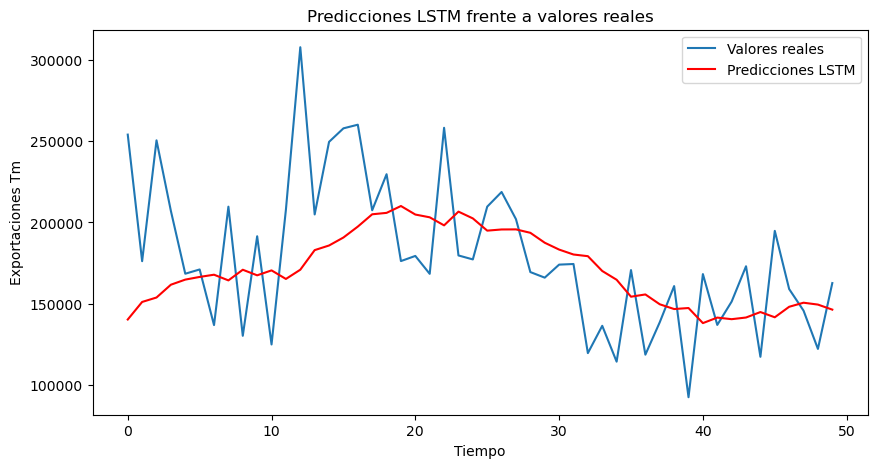

In [36]:
# Predicciones
y_pred = model.predict(X_test)

# Invertimos la escala de los datos de predicción y prueba para obtener valores reales
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculamos las métricas de error
mae = np.mean(np.abs(y_test_inv - y_pred_inv))
rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv) ** 2))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Visualizamos
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores reales')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones LSTM', color='red')
plt.title('Predicciones LSTM frente a valores reales')
plt.xlabel('Tiempo')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

La kñinea de predicciones del modelo LSTM muestra una tendencia menos reactiva a las fluctuaciones extremas presentes en la serie real. Esto indica que el modelo no está capturando completamente la variabilidad de la serie y tiende a suavizar los cambios bruscos.

Las métricas de error nos indican que no se está capturando la totalidad de la serie pero que los resultados parecen mejores que en los casos ARIMA y GXBoost.

Para intentar mejorar los resultados vamos a realizar algunos cambios en los parámetros del modelo y a añadir una segunda capa para capturar mejor las dependencias temporales que tenemos en nuestro caso de estudio

In [37]:
model2 = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 134ms/step - loss: 0.0754 - root_mean_squared_error: 0.2747 - val_loss: 0.2495 - val_root_mean_squared_error: 0.4995
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0463 - root_mean_squared_error: 0.2153 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0249 - val_root_mean_s

2/2 [==============================] - 1s 0s/step
MAE: 32820.4678125
RMSE: 42065.54104871896


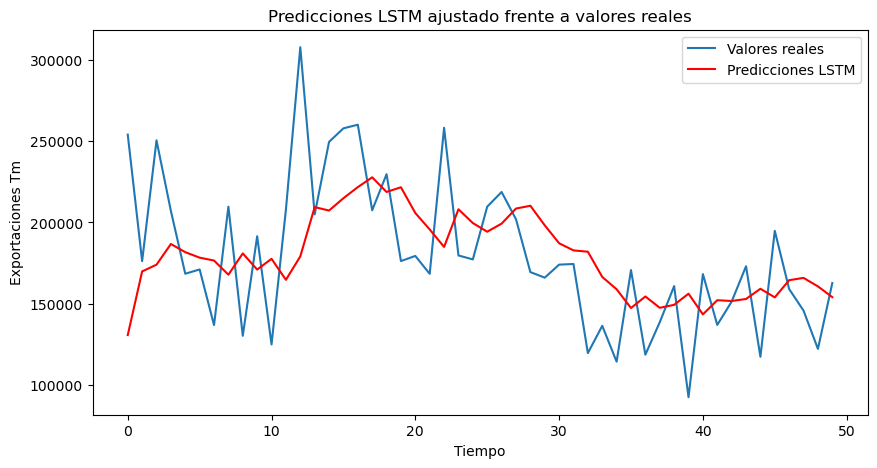

In [38]:
y_pred = model2.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae = np.mean(np.abs(y_test_inv - y_pred_inv))
rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv) ** 2))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores reales')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones LSTM', color='red')
plt.title('Predicciones LSTM ajustado frente a valores reales')
plt.xlabel('Tiempo')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

Los resultados son muy similares al primer modelado, incluso peores. Vamos a probar añadiendo una tercera capa y aumentanod los epochs a 100 para que el modelo tenga más tiempo de aprender patrones complejos.

In [39]:
model3 = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(25, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 114ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1436
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0107 - root_mean_squared_error: 0.1037 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 6/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0278 - val_root_mean_s

2/2 [==============================] - 0s 0s/step
MAE: 35954.6328125
RMSE: 43419.29080980201


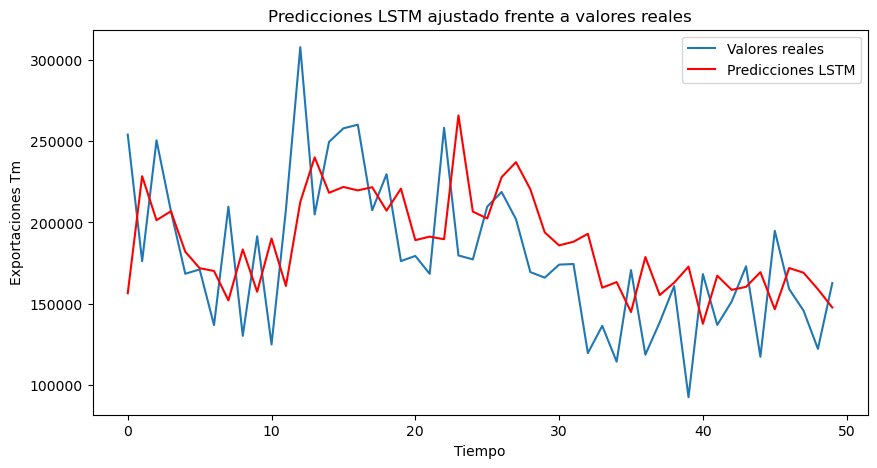

In [40]:
y_pred = model2.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae = np.mean(np.abs(y_test_inv - y_pred_inv))
rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv) ** 2))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores reales')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones LSTM', color='red')
plt.title('Predicciones LSTM ajustado frente a valores reales')
plt.xlabel('Tiempo')
plt.ylabel('Exportaciones Tm')
plt.legend()
plt.show()

Los resultados obtenidos con este tercer modelo LSTM, que incluye una tercera capa LSTM y un mayor número de épocas de entrenamiento, muestran mejoras notables en comparación con los modelos anteriores. Las predicciones muestran una alineación mucho más cercana con los valores reales, especialmente en términos de tendencia y la capacidad de seguir las oscilaciones. Aunque aún existen algunas discrepancias en los picos más pronunciados, el modelo capta de mejor manera las variaciones de corto plazo, lo que indica una mayor sensibilidad al comportamiento dinámico de la serie temporal.

#### Posibles mejoras:
Experimentar con arquitecturas LSTM bidireccionales o modelos híbridos que combinen LSTM con otros enfoques.